# Concert Audio power spectrum

Segment and Extract the amplitude envelope at 10 Hz of all intervals evaluated for motion from audience. Apply parallel analysis on 51.2 s frames.

In [6]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

from pydub import AudioSegment

import librosa.display
import IPython.display as ipd
from libfmp.b.b_plot import plot_signal, plot_chromagram
from libfmp.c3.c3s2_dtw_plot import plot_matrix_with_points
import libfmp.b

In [7]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'
# audio file locations in
audio_loc = '../Stimuli/Events/'
out_loc = '../Stimuli/Events/'
# audio file locations out
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [8]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:15,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,Claps 1,2,Clapping
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.08,377.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,1.05,Claps 1.1,4,Clapping
2021-10-26 17:47:02,-63.68,-63680,Speech MC2,Speech,1573.56,48.68,Speech 3,5,Speech
2021-10-26 17:47:51,-15.00,-15000,preTaps 1,Synchronisation,1622.24,15.00,preSynch 1,6,
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,Synch 1,7,
2021-10-26 17:48:20,14.38,14380,Clapping in Musicians,Applause,1651.62,43.02,Claps 2,8,Clapping


In [9]:
ETypes = ['Music','Survey','Speech','Applause']

M_times = Main_concert_times.query('Event_Duration>55 and Event_Type in @ETypes')# for frequency analysis
M_times.iloc[:5,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.08,377.52,Speech 2,3,Speech
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,Beeth. 1,9,Beethoven
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music,2113.32,225.10,Beeth. 2,10,Beethoven
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music,2338.42,468.98,Beeth. 3,11,Beethoven


In [10]:
sound = AudioSegment.from_wav('../Stimuli/Full_Live_Concert_Mono.wav') #1637.224
#sound = AudioSegment.from_mp3(audio_loc) 
print(len(sound))

11229056


In [11]:
# buffer is small, 1 second
t_units = 1000  # pydub does things in milliseconds
buff = 0 # in seconds
concert  = 'Copen'
for i in M_times.index:
    Peice_tag = '_'.join(M_times.loc[i,'Shorter_tag'].split(' ')).replace("._", "_")
    s_time = (M_times.loc[i,'Time_Stream']-buff) * t_units
    e_time = (M_times.loc[i,'Time_Stream']+ M_times.loc[i,'Event_Duration']+buff) * t_units
    p_audio = sound[s_time:e_time]
    out_audio = out_loc + M_times.loc[i,'Event_Type'] + '_' + Peice_tag + '.wav'
    print(out_audio)
    with open(out_audio, 'wb') as out_f:
        p_audio.export(out_f, format='wav')

../Stimuli/Events/Speech_Speech_1.wav
../Stimuli/Events/Speech_Speech_2.wav
../Stimuli/Events/Music_Beeth_1.wav
../Stimuli/Events/Music_Beeth_2.wav
../Stimuli/Events/Music_Beeth_3.wav
../Stimuli/Events/Music_Beeth_4.wav
../Stimuli/Events/Survey_Survey_1.wav
../Stimuli/Events/Music_Schnit_1.wav
../Stimuli/Events/Music_Schnit_2.wav
../Stimuli/Events/Music_Schnit_3.wav
../Stimuli/Events/Applause_Claps_5.wav
../Stimuli/Events/Speech_Speech_6.wav
../Stimuli/Events/Survey_Survey_2.wav
../Stimuli/Events/Speech_Speech_7.wav
../Stimuli/Events/Music_Bach.wav
../Stimuli/Events/Survey_Survey_3.wav
../Stimuli/Events/Speech_Speech_9.wav
../Stimuli/Events/Music_Folk_1.wav
../Stimuli/Events/Music_Folk_2.wav
../Stimuli/Events/Music_Folk_3.wav
../Stimuli/Events/Music_Folk_4.wav
../Stimuli/Events/Music_Folk_5.wav
../Stimuli/Events/Music_Folk_6.wav
../Stimuli/Events/Applause_Claps_14.wav
../Stimuli/Events/Survey_Survey_4.wav


In [12]:
def get_spectrogram(datain,F,W,J,scale='log'):
    '''Makes a spectrogram of the given data.
    #
    df: dataframe with data
    F: sampling frequency
    W: Window size
    J: Separation between windows
    #
    output: if input is Series output is a signle DF with spectrogram
            if intput is DF the output is dictionary with one spectrogram per column of the input dataframe
    '''
    K = range(0,len(datain)-W,J) # starting point for the windows
    K0 = [int(x+W/2) for x in K] # placing them in the middle point timestamp
    new_index = [datain.index[x] for x in K0] # extracting those timestamps
    col_freqs = [x*F/W for x in range(int(W/2)+1) ] # values of resolved freqs
    #   print(len(new_index),len(col_freqs))
    han = np.hanning(W)
    #dic = {'window_size':W,'sampling_frequency':F}
    #
    dic = {}
    for col in datain.columns:
        fourier = np.zeros((len(new_index),len(col_freqs)))
        temp = np.zeros((1,int(W/2)+1))
        j = 0
        D = datain[col]
#         D = D.diff() # discrete derivative
        D = D.dropna() # discarding nans and concatenating
        if len(D)==0:
            continue
        #   
        K0 = range(0,len(D)-W,J) # starting point for the windows
        for T0 in K0:
            data0 = D.iloc[T0:T0+W]*han
            if scale=='log':
                temp = 10*np.log10(2*abs(np.fft.fft(data0,axis=0)))
            elif scale=='abs':
                temp = abs(np.fft.fft(data0,axis=0))
            fourier[j,:] = temp[:int(W/2)+1]
            j = 1 + j
            #
        res = pd.DataFrame(fourier,index=new_index,columns=col_freqs)
#         res1 = res / (res.columns) # multiplicative adjustment for discrete derivative
        dic[col] = res#1      
        #print('Ready with ',col)
    output = dic
    #
    return output
#
def get_meanpowerspectrum(datain,F,W,J,scale='log'):
    # Obtained average spectrogram using the previous function
    spectrogram = get_spectrogram(datain,F,W,J,scale)
    dic = {}
    for key in spectrogram:
        dic[key] = spectrogram[key].mean(axis=0)
    output = pd.DataFrame(dic,index=dic[key].index)
    return output
#
#

In [13]:
# https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S3_Dynamics.html
def compute_power_db(x, Fs, win_len_sec=0.1, power_ref=10**(-12)):
    """Computation of the signal power in dB

    Notebook: C1/C1S3_Dynamics.ipynb

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        Fs (scalar): Sampling rate
        win_len_sec (float): Length (seconds) of the window (Default value = 0.1)
        power_ref (float): Reference power level (0 dB) (Default value = 10**(-12))

    Returns:
        power_db (np.ndarray): Signal power in dB
    """
    win_len = round(win_len_sec * Fs)
    win = np.ones(win_len) / win_len
    power_db = 10 * np.log10(np.convolve(x**2, win, mode='same') / power_ref)
    return power_db

In [14]:
audioFile = '../Stimuli/Events/Speech_Speech_1.wav'

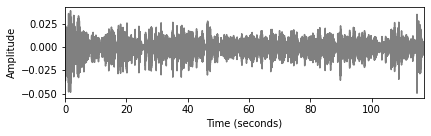

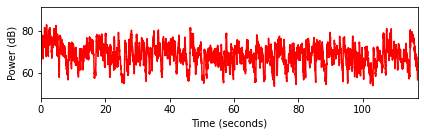

In [15]:
# fn_wav = os.path.join('..', 'data', 'C1', 'FMP_C1_F10_Beethoven_Fifth-MM1-21_Karajan1946.wav')
Fs = 48000 #48 kHz
x, Fs = librosa.load(audioFile, sr=Fs, mono=True)

win_len_sec = 0.1
power_db = compute_power_db(x, win_len_sec=win_len_sec, Fs=Fs)

libfmp.b.plot_signal(x, Fs=Fs, ylabel='Amplitude')
plt.show()

libfmp.b.plot_signal(power_db, Fs=Fs, ylabel='Power (dB)', color='red')
# plt.ylim([70, 110])
plt.show()

<Axes: >

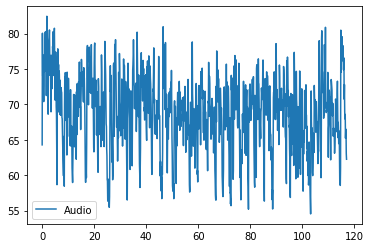

In [16]:
ts = np.arange(0,len(power_db),int(Fs*win_len_sec))/Fs
envel = power_db[np.arange(0,len(power_db),int(Fs*win_len_sec))] #Fs*win_len_sec

seg = pd.DataFrame(index = ts,data = envel,columns=['Audio'])
seg.plot()

In [17]:
sF = 10
FrameSize = 2**9
HopSize = 100

Fs = 48000 #48 kHz
win_len_sec = 0.1

ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')

Specs = {}
for i,r in MTs.iterrows():
    Peice_tag = '_'.join(r['Shorter_tag'].split(' ')).replace("._", "_")
    audioFile = out_loc + r['Event_Type'] + '_' + Peice_tag + '.wav'
    print(audioFile)
    x, Fs = librosa.load(audioFile, sr=Fs, mono=True)
    power_db = compute_power_db(x, win_len_sec=win_len_sec, Fs=Fs)
    ts = np.arange(0,len(power_db),int(Fs*win_len_sec))/Fs
    envel = power_db[np.arange(0,len(power_db),int(Fs*win_len_sec))] #Fs*win_len_sec
    seg = pd.DataFrame(index = ts,data = envel,columns=['Audio'])
    
    Specs[r['Shorter_tag']] = get_meanpowerspectrum(seg,sF,FrameSize,HopSize,scale='abs')

../Stimuli/Events/Speech_Speech_1.wav
../Stimuli/Events/Speech_Speech_2.wav
../Stimuli/Events/Music_Beeth_1.wav
../Stimuli/Events/Music_Beeth_2.wav
../Stimuli/Events/Music_Beeth_3.wav
../Stimuli/Events/Music_Beeth_4.wav
../Stimuli/Events/Survey_Survey_1.wav
../Stimuli/Events/Music_Schnit_1.wav
../Stimuli/Events/Music_Schnit_2.wav
../Stimuli/Events/Music_Schnit_3.wav
../Stimuli/Events/Applause_Claps_5.wav
../Stimuli/Events/Survey_Survey_2.wav
../Stimuli/Events/Speech_Speech_7.wav
../Stimuli/Events/Music_Bach.wav
../Stimuli/Events/Survey_Survey_3.wav
../Stimuli/Events/Music_Folk_1.wav
../Stimuli/Events/Music_Folk_2.wav
../Stimuli/Events/Music_Folk_3.wav
../Stimuli/Events/Music_Folk_4.wav
../Stimuli/Events/Music_Folk_5.wav
../Stimuli/Events/Music_Folk_6.wav
../Stimuli/Events/Applause_Claps_14.wav
../Stimuli/Events/Survey_Survey_4.wav


In [18]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
SuperSpecs = {}
for ev in ev_tags:
    sub_evs = Main_concert_times.query('Event.str.startswith(@ev)and Event_Duration > @minDur')
    Parts = ['Audio']
    df_parts = pd.DataFrame(columns = Parts)
    for partID in Parts:
        df=pd.DataFrame()
        for s in sub_evs['Shorter_tag']:
            if partID in Specs[s].columns:
                df[s] = Specs[s].loc[:,partID].copy()
        df_parts[partID] = df.mean(axis=1)
    SuperSpecs[ev]=df_parts.copy()

In [19]:
D_evs = []
for ev in SuperSpecs.keys(): # just in hall
    df = SuperSpecs[ev].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
D = pd.concat(D_evs,axis=0)
D.replace([np.inf, -np.inf], np.nan, inplace=True)
D = D.dropna()

D_evs = []
for ev in Specs.keys(): # just in hall
    df = Specs[ev].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
Ds = pd.concat(D_evs,axis=0)
Ds.replace([np.inf, -np.inf], np.nan, inplace=True)
Ds = Ds.dropna()

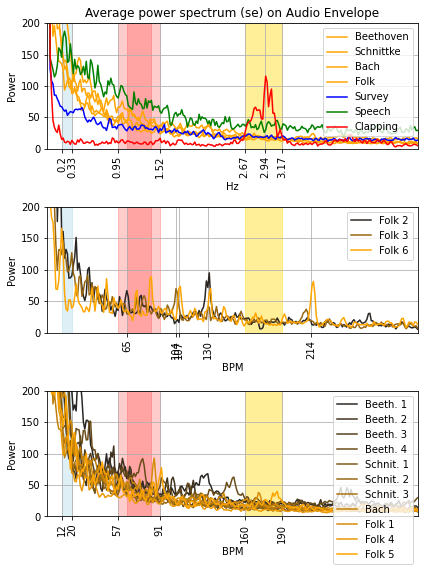

In [20]:
# General aspect of figure
fig, axes = plt.subplots(3,1,figsize=(6, 8))# ,sharex=True
errorbarType ='se' # 'ci' #
#
ax=axes[0]
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette=Event_palette,ax=ax)
# sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',errorbar='se',err_style='band', palette=Event_palette,ax=ax)
ax.set(xlim=(0,5), ylim=(0, 200))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(1.08333333, 1.4 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(0.95      , 1.51666667,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
Hzs = np.array([12,20,57,91,160,176.5,190])/60#74,
ax.set_xticks(Hzs)
ax.set_xticklabels(np.round(Hzs,2),rotation=90)
ax.set_xlabel('Hz')
ax.legend(loc='upper right')
ax.set_title('Average power spectrum (' + errorbarType + ') on Audio Envelope')
ax.grid()

ax=axes[2]
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach','Folk 1','Folk 4', 'Folk 5', ]
Ds_sub = Ds.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette="dark:orange",ax=ax)
ax.legend(loc='upper right')
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(1.08333333, 1.4 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(0.95      , 1.51666667,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
BPMs = np.array([12,20,57,91,160,190])#74,
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=90)
ax.set_xlabel('BPM')
ax.set(xlim=(0,5),ylim=(0, 200))
ax.grid()

ax=axes[1]
sub_evs = ['Folk 2', 'Folk 3', 'Folk 6']
Ds_sub = Ds.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',hue_order = sub_evs,palette="dark:orange", errorbar=errorbarType,err_style='band',ax=ax) #
ax.set(xlim=(0,5),ylim=(0, 200))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(1.08333333, 1.4 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(0.95      , 1.51666667,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
BPMs = np.array([65,104,107,130,214])#74,
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=90)
ax.set_xlabel('BPM')
ax.legend(loc='upper right')
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Audio.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

The audio from the concert shows similar energies to the audience's actions. Applause shows a peak matching the energy measured across the audience's accelerometers